In [1]:
%pylab inline
import numpy as np
import sys
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from scipy.stats import wasserstein_distance

import sys
sys.path.append('../../core/')
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [5]:
loss_types = ['MSE', 'RE', 'OW','AOW']
taus = [2.0,4.0,6.0,8.0,10.0]
Omega = np.logspace(-4,-1,20)
n_restarts = 20
path = '../../saved_results/kol/'

In [6]:
if False:

    Results = {}

    def compute_output_dist(D):

        D_hist, D_bins = np.histogram(D, density = True, bins='auto')

        D_order = np.argsort(D)
        D_sorted = np.sort(D)
        inds = [np.min(np.where(D_sorted >= e)) for e in D_bins[:-1]] + [len(D)]

        D_density = np.zeros_like(D)
        for j in range(len(D_bins)-1):
            D_density[D_order[inds[j]:inds[j+1]]] = D_hist[j]

        return D_density

    for loss_type in loss_types:
        for tau in taus:

            filename = path+'results_loss_'+loss_type+'_tau'+str(tau)+'.npy'
            Results[loss_type, tau] = np.load(filename, allow_pickle=True).item()

            Results[loss_type,tau]['NN_mean'] = np.mean(np.vstack([Results[loss_type, tau]['NN_'+str(j+1)] 
                                                         for j in range(n_restarts)]), axis=0)

            Results[loss_type,tau]['error'] = np.vstack([Results[loss_type, tau]['true'].flatten()-
                                                         Results[loss_type, tau]['NN_'+str(j+1)]
                                                         for j in range(n_restarts)])

            Results[loss_type,tau]['density'] = compute_output_dist(Results[loss_type, tau]['true'])

    Alpha = {}
    
    sample_rate = 10

    for tau in taus:
        
        m_tv = int(0.6*len(Results[loss_types[0],tau]['true']))
        for loss_type in loss_types:

            Alpha[loss_type,tau] = np.zeros((n_restarts, len(Omega)))
            true = Results[loss_type, tau]['true'][m_tv::sample_rate].flatten()

            for i in tqdm(range(n_restarts)):
                pred = Results[loss_type, tau]['NN_'+str(i+1)][m_tv::sample_rate].flatten()
                gAUC = get_AUC_grid(true, pred, Q=Omega)[1]
                Alpha[loss_type,tau][i,:] = gAUC

    np.save(path + 'Alpha.npy', Alpha)
    
else:
    
    Alpha = np.load(path + 'Alpha.npy', allow_pickle=True).item()

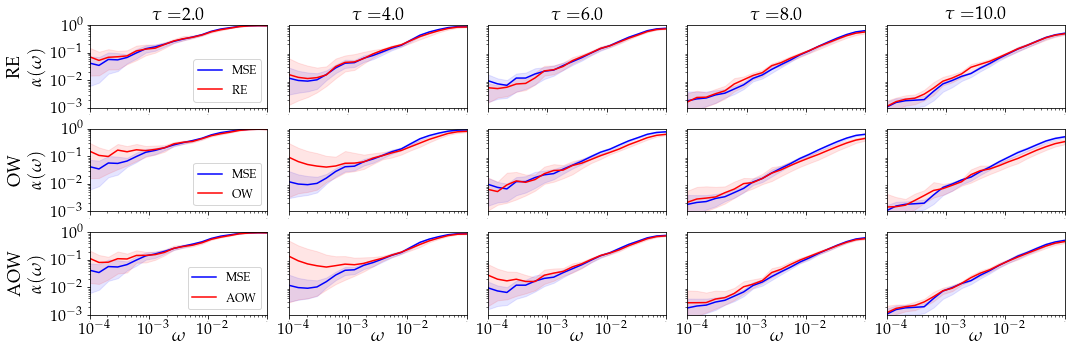

In [8]:
figure(figsize = (15,5))
label_fs = 18
alpha = 0.1
pct = 10

for i in range(len(taus)):
    for j in range(len(loss_types)-1):

        ax=subplot2grid((3,len(taus)),(j,i))
        
        plot(Omega, np.mean(Alpha[loss_types[0],taus[i]],axis=0), 'b', label='MSE')
        fill_between(Omega, 
                     np.percentile(Alpha[loss_types[0],taus[i]],pct,axis=0), 
                     np.percentile(Alpha[loss_types[0],taus[i]],100-pct,axis=0), 
                     color='b', alpha=0.1)

        plot(Omega, np.mean(Alpha[loss_types[j+1],taus[i]],axis=0), 'r', label=loss_types[j+1])
        fill_between(Omega, 
                     np.percentile(Alpha[loss_types[j+1],taus[i]],pct,axis=0), 
                     np.percentile(Alpha[loss_types[j+1],taus[i]],100-pct,axis=0), 
                     color='r', alpha=0.1)
        
        xlim(Omega[0], Omega[-1])
        yscale('log')
        xscale('log')
        ylim([1e-3,1])

        if j==2:
            xlabel(r'$\omega$', fontsize = label_fs)
            xticks(fontsize = 0)
        else:
            xticks(fontsize=0)
        if j==0:
            title(r'$\tau=$'+str(taus[i]), fontsize = label_fs)

        if i==0:
            label = r''+loss_types[j+1]+'\n$\\alpha ( \omega )$'
            ylabel(label, fontsize = label_fs)
            yticks(fontsize = label_fs-2)
            legend(loc = 'lower right', fontsize = label_fs-6, ncol=1)
        else:
            yticks([], fontsize=0)
            
        if j == 2:
            text(10**-4.2, 10**-3.7, r'$10^{-4}$', fontsize = label_fs-2)
            text(10**-3.2, 10**-3.7, r'$10^{-3}$', fontsize = label_fs-2)
            text(10**-2.2, 10**-3.7, r'$10^{-2}$', fontsize = label_fs-2)
#             text(10**-1.2, 10**-3.7, r'$10^{-1}$', fontsize = label_fs-2)

tight_layout()